In [1]:
import sys
import os
sys.path.append(os.path.abspath('../src'))

In [2]:
from data_pipeline import load_dataset
import numpy as np
import matplotlib.pyplot as plt

X_train, y_train, label_map_train = load_dataset('../data/Brain Cancer Dataset/Training', add_noise=True)

print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)

print("label_map_train:", label_map_train)

X_train shape: (5712, 224, 224)
y_train shape: (5712,)
label_map_train: {'glioma': 1, 'meningioma': 2, 'notumor': 3, 'pituitary': 4}


In [3]:
X_test, y_test, _ = load_dataset('../data/Brain Cancer Dataset/Testing', add_noise=False)

print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)

X_test shape: (1311, 224, 224)
y_test shape: (1311,)


In [4]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, Flatten, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping

In [5]:
# remap y to 0-based indexing
inverse_label_map = {v: i for i, v in enumerate(sorted(label_map_train.values()))}

y_train_mapped = np.array([inverse_label_map[y] for y in y_train])
y_test_mapped = np.array([inverse_label_map[y] for y in y_test])

In [6]:
#check correct
print("Unique new labels:", np.unique(y_train_mapped))

Unique new labels: [0 1 2 3]


In [9]:
# convert to 3 channel input even though MRI are grayscale
X_train_rgb = np.repeat(X_train[..., np.newaxis], 3, axis=-1)

# one-hot encode labels
num_classes = len(label_map_train)
y_train_cat = to_categorical(y_train_mapped, num_classes)
#check
print("One-hot shape:", y_train_cat.shape)


One-hot shape: (5712, 4)


In [10]:
input_shape = (224, 224, 3) 

base_model = VGG16(weights='imagenet', include_top=False, input_shape=input_shape)
base_model.trainable = False # Freeze the base model

x = Flatten()(base_model.output)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
output = Dense(num_classes, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=output)

2025-06-06 14:47:20.920207: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M2 Pro
2025-06-06 14:47:20.920234: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2025-06-06 14:47:20.920250: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2025-06-06 14:47:20.920287: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-06-06 14:47:20.920300: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [11]:
model.compile(optimizer=Adam(learning_rate=1e-4),
                loss='categorical_crossentropy',
                metrics=['accuracy'])

In [12]:
import tensorflow as tf
print("GPUs:", tf.config.list_physical_devices('GPU'))

GPUs: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [18]:
history = model.fit(X_train_rgb, y_train_cat,
        epochs=10,
        batch_size=32,
        validation_split=0.2)

Epoch 1/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 34s 234ms/step - accuracy: 0.9809 - loss: 0.0547 - val_accuracy: 0.8994 - val_loss: 0.4998
Epoch 2/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 33s 232ms/step - accuracy: 0.9923 - loss: 0.0216 - val_accuracy: 0.9020 - val_loss: 0.5111
Epoch 3/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 33s 234ms/step - accuracy: 0.9887 - loss: 0.0359 - val_accuracy: 0.9020 - val_loss: 0.4843
Epoch 4/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 33s 230ms/step - accuracy: 0.9923 - loss: 0.0229 - val_accuracy: 0.9178 - val_loss: 0.4153
Epoch 5/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 33s 230ms/step - accuracy: 0.9912 - loss: 0.0214 - val_accuracy: 0.8871 - val_loss: 0.5783
Epoch 6/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 33s 230ms/step - accuracy: 0.9921 - loss: 0.0222 - val_accuracy: 0.8854 - val_loss: 0.6028
Epoch 7/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 33s 230ms/step - accuracy: 0.9937 - loss: 0.0206 - val_accuracy: 0.8845 - val_loss: 0.5796
Epoch 8/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 33s 230ms/step - accuracy: 0.9905 - loss: 0

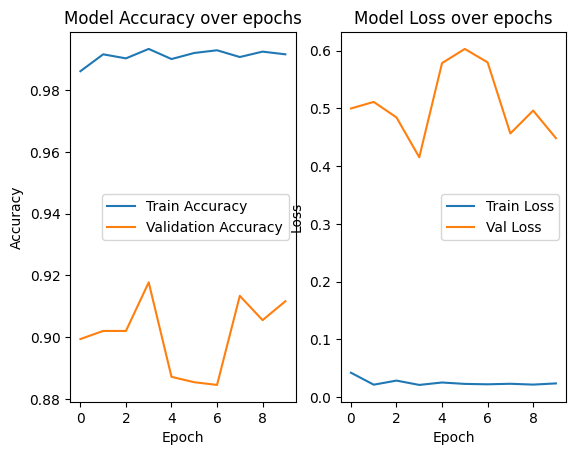

In [28]:
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy over epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# loss plot
plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Model Loss over epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [21]:
# convert to 3 channel input even though MRI are grayscale
X_test_rgb = np.repeat(X_test[..., np.newaxis], 3, axis=-1)

# one-hot encode labels
num_classes = len(label_map_train)
y_test_cat = to_categorical(y_test_mapped, num_classes)
#check
print("One-hot shape:", y_test_cat.shape)


One-hot shape: (1311, 4)


41/41 ━━━━━━━━━━━━━━━━━━━━ 8s 189ms/step


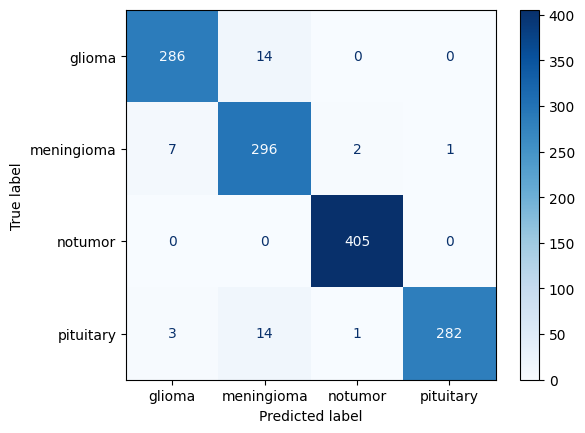

In [23]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

y_pred_probs = model.predict(X_test_rgb)
y_pred = np.argmax(y_pred_probs, axis=1)

cm = confusion_matrix(y_test_mapped, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=list(label_map_train.keys()))
disp.plot(cmap=plt.cm.Blues)
plt.show()

In [26]:
# using VGG16 as a feature extractor
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

# load VGG16 model without the top layer
vgg = VGG16(weights='imagenet', include_top=False, input_shape=input_shape)
vgg.trainable = False  # Freeze the base model

model = Model(inputs=vgg.input, outputs=vgg.output)


# Extract features from training data
x_train_features = model.predict(X_train_rgb)
x_test_features = model.predict(X_test_rgb)

# flatten
X_train_flat = x_train_features.reshape(x_train_features.shape[0], -1)
X_test_flat = x_test_features.reshape(x_test_features.shape[0], -1)

179/179 ━━━━━━━━━━━━━━━━━━━━ 33s 184ms/step
41/41 ━━━━━━━━━━━━━━━━━━━━ 8s 182ms/step


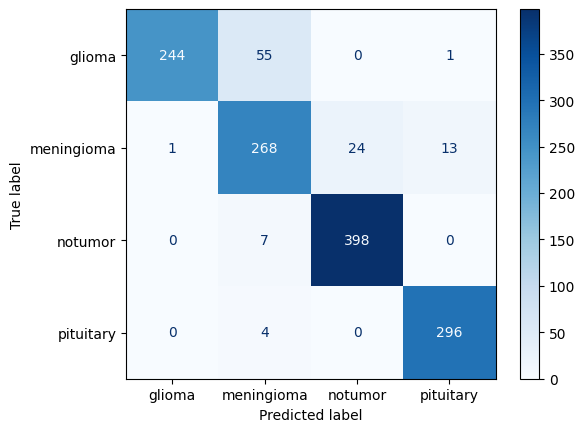

In [27]:
clf = SVC(kernel='rbf')
clf.fit(X_train_flat, y_train_mapped)

#pred
y_test_pred = clf.predict(X_test_flat)

cm = confusion_matrix(y_test_mapped, y_test_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=list(label_map_train.keys()))
disp.plot(cmap=plt.cm.Blues)
plt.show()

In [ ]:
# train from scratch 

scratch_model = VGG16(weights=None, include_top=False, input_shape=input_shape)
scratch_model.trainable = True  # Train the base model

